# Covid-19's Impact on Airport Traffic Analysis

## 1. Install Packages & Load the Dataset

In [1]:
# Run the following lines to install needed packages.
# pip install pandas 
# pip install numpy
# pip install matplotlib 
# pip install folium 

In [2]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import folium
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import datetime as dt
from scipy.stats import pearsonr
from scipy.stats import spearmanr

In [3]:
# First dataset (Main dataset)
cat = pd.read_csv('archive/covid_impact_on_airport_traffic.csv') # cat == covid_airport_traffic
cat.head()

,AggregationMethod,Date,Version,AirportName,PercentOfBaseline,Centroid,City,State,ISO_3166_2,Country,Geography
0,Daily,2020-04-03,1.0,Kingsford Smith,64,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
1,Daily,2020-04-13,1.0,Kingsford Smith,29,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
2,Daily,2020-07-10,1.0,Kingsford Smith,54,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
3,Daily,2020-09-02,1.0,Kingsford Smith,18,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
4,Daily,2020-10-31,1.0,Kingsford Smith,22,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."


In [4]:
# Second dataset provides auxillary information on statistics of confirmed covid-19 patient.
covid_comfirmed_case = pd.read_csv('archive/time_series_covid19_confirmed_global.csv')
covid_comfirmed_case.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,8/29/21,8/30/21,8/31/21,9/1/21,9/2/21,9/3/21,9/4/21,9/5/21,9/6/21,9/7/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,152960,153148,153220,153260,153306,153375,153375,153375,153534,153626
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,144847,145333,146387,147369,148222,149117,150101,150997,151499,152239
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,195162,195574,196080,196527,196915,197308,197659,198004,198313,198645
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,15025,15032,15033,15046,15052,15055,15055,15055,15069,15070
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,47168,47331,47544,47781,48004,48261,48475,48656,48790,49114


## 2. Preprocessing

In [5]:
# Null detection and handling
df = cat.copy(deep=True)
print(df.isnull().sum())
df = cat.dropna()

AggregationMethod    0
Date                 0
Version              0
AirportName          0
PercentOfBaseline    0
Centroid             0
City                 0
State                0
ISO_3166_2           0
Country              0
Geography            0
dtype: int64


In [6]:
# Drop Non-important columns
df2 = covid_comfirmed_case.copy(deep=True)
print(df2.isnull().sum())
df2.drop(['Lat', 'Long'], axis=1, inplace=True)

Province/State    192
Country/Region      0
Lat                 2
Long                2
1/22/20             0
                 ... 
9/3/21              0
9/4/21              0
9/5/21              0
9/6/21              0
9/7/21              0
Length: 599, dtype: int64


In [7]:
# Sort the data by Date column
df_date = df.copy(deep=True)
df_date = df.sort_values(by=['Date']).reset_index(drop=True)
df_date['Date'] = pd.to_datetime(df_date['Date'], format='%Y-%m-%d')
df_date.head()

,AggregationMethod,Date,Version,AirportName,PercentOfBaseline,Centroid,City,State,ISO_3166_2,Country,Geography
0,Daily,2020-03-16,1.0,Santiago International Airport,96,POINT(-70.7942372739446 -33.3907265266744),Santiago,Santiago Province,CL,Chile,"POLYGON((-70.8043956756592 -33.3719683869737, ..."
1,Daily,2020-03-16,1.0,Halifax International,72,POINT(-63.5116720134583 44.8830168353507),Halifax,Nova Scotia,CA-NS,Canada,"POLYGON((-63.5266613960266 44.8984438169036, -..."
2,Daily,2020-03-16,1.0,Hartsfield-Jackson Atlanta International,92,POINT(-84.4279188822754 33.6410758198944),College Park,Georgia,US-GA,United States of America (the),"POLYGON((-84.4299745559692 33.657852680999, -8..."
3,Daily,2020-03-16,1.0,Los Angeles International,98,POINT(-118.404993180627 33.941369379328),Los Angeles,California,US-CA,United States of America (the),"POLYGON((-118.439612388611 33.9517616366508, -..."
4,Daily,2020-03-16,1.0,McCarran International,68,POINT(-115.14888081287 36.082853976328),Paradise,Nevada,US-NV,United States of America (the),"POLYGON((-115.158487558365 36.1007120735771, -..."


## 3. Data Analysis and Visualization

3a. Overall Statistics

In [8]:
print("The number of rows of covid_impact_on_airport_traffic dataset is " + str(len(df)) + ".")
airport_names = df['AirportName'].unique()
country_names = df['Country'].unique()
ISO_names = df['ISO_3166_2'].unique()
state_names = df['State'].unique()
city_names = df['City'].unique()
print(airport_names)
print('airport_numbers:' + str(len(airport_names)) + '\n')
print(country_names)
print('country_numbers:' + str(len(country_names)) + '\n')
print(ISO_names)
print('ISO_numbers:' + str(len(ISO_names)) + '\n')
print(state_names)
print('state_numbers:' + str(len(state_names)) + '\n')
print(city_names)
print('city_numbers:' + str(len(city_names)) + '\n')

The number of rows of covid_impact_on_airport_traffic dataset is 7247.
['Kingsford Smith' 'Santiago International Airport'
 'Calgary International' 'Edmonton International'
 'Vancouver International' 'Winnipeg International'
 'Halifax International' 'Toronto Pearson' 'Hamilton International'
 'Montreal Mirabel' 'Montreal Trudeau' 'Los Angeles International'
 'San Francisco International' 'Denver International'
 'Miami International ' 'Hartsfield-Jackson Atlanta International '
 'Daniel K. Inouye International ' 'Chicago OHare International'
 'Boston Logan International ' 'Detroit Metropolitan Wayne County '
 'Charlotte Douglas International' 'Newark Liberty International '
 'McCarran International' 'LaGuardia' 'John F. Kennedy International'
 'Dallas/Fort Worth International ' 'Washington Dulles International '
 'Seattle-Tacoma International ']
airport_numbers:28

['Australia' 'Chile' 'Canada' 'United States of America (the)']
country_numbers:4

['AU' 'CL' 'CA-AB' 'CA-BC' 'CA-MB' 'CA-N

3b. Geographical Map of all airports

In [9]:
# Create a sepeate dataframe with AirportName, City and Country
df_geo = df.copy(deep=True)
df_geo = df[['AirportName','Centroid','City','State','Country']]
# Remove repeated rows (Unique values)
df_geo = df_geo.drop_duplicates(subset=["AirportName"], ignore_index=True)
# Adding new columns for longitudes and latitudes as numbers
df_geo['Long'], df_geo['Lat'] = df_geo['Centroid'].str.split(' ').str
df_geo['Long'] = df_geo['Long'].str[6:].astype(float)
df_geo['Lat'] = df_geo['Lat'].str[:-1].astype(float)
df_geo.head()

<ipython-input-9-ae4ab70c5dfe>:7: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df_geo['Long'], df_geo['Lat'] = df_geo['Centroid'].str.split(' ').str


,AirportName,Centroid,City,State,Country,Long,Lat
0,Kingsford Smith,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,Australia,151.180088,-33.945977
1,Santiago International Airport,POINT(-70.7942372739446 -33.3907265266744),Santiago,Santiago Province,Chile,-70.794237,-33.390727
2,Calgary International,POINT(-114.013122872131 51.1184753727795),Calgary,Alberta,Canada,-114.013123,51.118475
3,Edmonton International,POINT(-113.576260685047 53.308783097969),Leduc County,Alberta,Canada,-113.576261,53.308783
4,Vancouver International,POINT(-123.17754124324 49.1935788600694),Richmond,British Columbia,Canada,-123.177541,49.193579


In [10]:
airport_map = folium.Map(location=None)

marker = folium.FeatureGroup()
# Previous overall statistics showed that we have 4 countries: Australia, Chile, Canada and the United States of America
# We label airport belonging to different countries with different colors:
# Green: Australia
# Orange: Chile
# Red: Canada
# Blue: the United States of America
for i in range(len(df_geo)):
    country_color = 'blue'
    if df_geo.loc[i, 'Country'] == 'Australia':
        country_color = 'green'
    elif df_geo.loc[i, 'Country'] == 'Chile':
        country_color = 'orange'
    elif df_geo.loc[i, 'Country'] == 'Canada':
        country_color = 'red'
    
    marker.add_child(
        folium.Marker(
            location = [df_geo.loc[i, 'Lat'], df_geo.loc[i, 'Long']],
            popup = '[AirportName]: ' + df_geo.loc[i, 'AirportName'] +
            '. \n [Country]: ' + df_geo.loc[i, 'Country'] +
            '. \n [State]: ' + df_geo.loc[i, 'State'] +
            '. \n [City]: ' + df_geo.loc[i, 'City'] + '.',
            icon = folium.Icon(color=country_color, icon='plane')
        )
    )

airport_map.add_child(marker)
airport_map.add_child(folium.map.LayerControl())
airport_map

3c. Mean bar plots of each country, state, city and airports

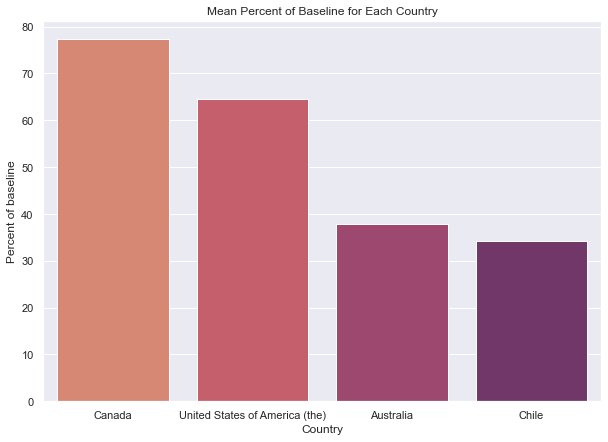

In [11]:
# From Frank's work in python file: summary_visualization
# show mean of PercentOfBaseline each country
mean_pob = df.groupby('Country')['PercentOfBaseline'].mean().sort_values(ascending=False).reset_index()
sns.set(font_scale=1.0)
plt.figure(figsize=[10, 7])
sns.barplot(data=mean_pob, x='Country', y='PercentOfBaseline', palette='flare')
plt.ylabel('Percent of baseline')
plt.title('Mean Percent of Baseline for Each Country')
plt.show()

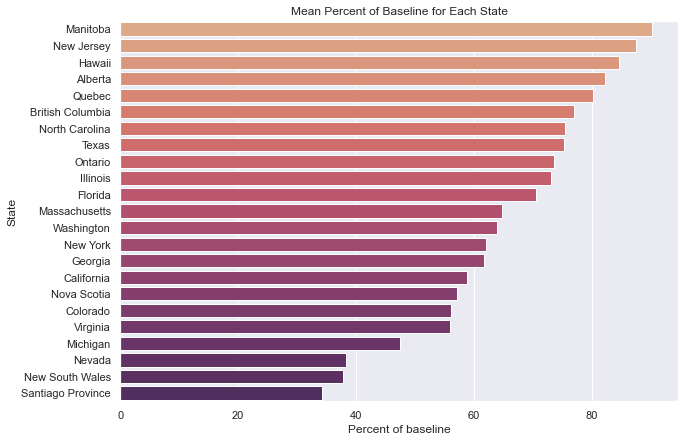

In [12]:
# show mean of PercentOfBaseline each state
mean_pob = df.groupby('State')['PercentOfBaseline'].mean().sort_values(ascending=False).reset_index()
sns.set(font_scale=1.0)
plt.figure(figsize=[10, 7])
sns.barplot(data=mean_pob, x='PercentOfBaseline', y='State', palette='flare')
plt.xlabel('Percent of baseline')
plt.title('Mean Percent of Baseline for Each State')
plt.show()

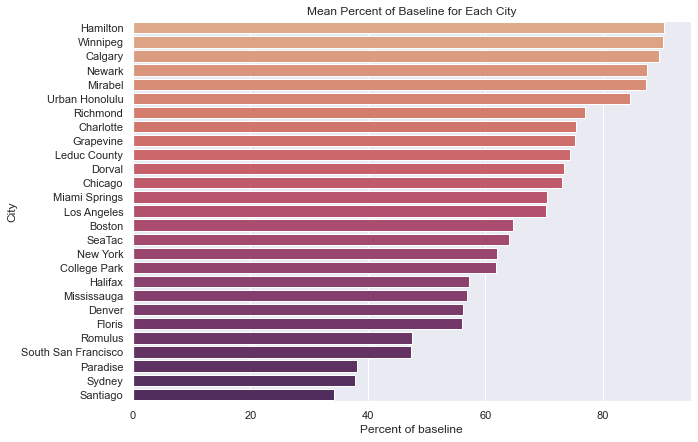

In [13]:
# show mean of PercentOfBaseline each city
mean_pob = df.groupby('City')['PercentOfBaseline'].mean().sort_values(ascending=False).reset_index()
sns.set(font_scale=1.0)
plt.figure(figsize=[10, 7])
sns.barplot(data=mean_pob, x='PercentOfBaseline', y='City', palette='flare')
plt.xlabel('Percent of baseline')
plt.title('Mean Percent of Baseline for Each City')
plt.show()

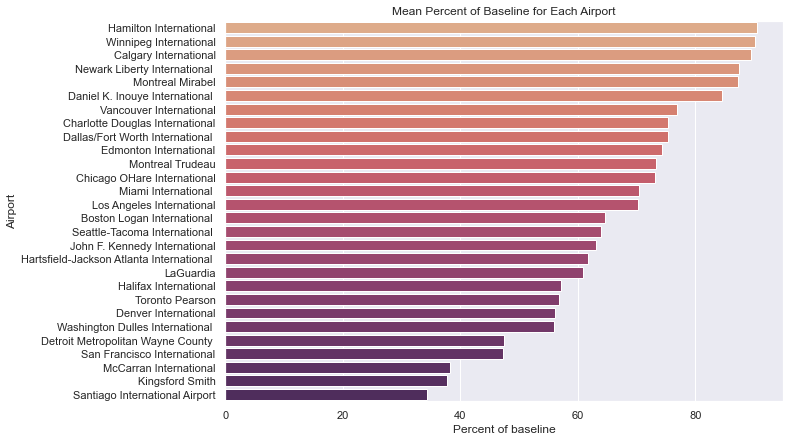

In [14]:
# show mean of PercentOfBaseline each airport
mean_pob = df.groupby('AirportName')['PercentOfBaseline'].mean().sort_values(ascending=False).reset_index()
sns.set(font_scale=1.0)
plt.figure(figsize=[10, 7])
sns.barplot(data=mean_pob, x='PercentOfBaseline', y='AirportName', palette='flare')
plt.xlabel('Percent of baseline')
plt.ylabel('Airport')
plt.title('Mean Percent of Baseline for Each Airport')
plt.show()

3d. Mean activity (PercentOfBaseline) graph by month

In [15]:
# We group all data by month
group_of_month = df_date.groupby(by=df_date['Date'].dt.month)
df_month = pd.DataFrame()
df_month['Month'] = df_date['Date'].dt.month.unique()

# Mean Percect Baseline arrays
total_mpct = []
chile_mpct = []
ca_mpct = []
us_mpct = []
au_mpct = []
for i in df_month['Month']:
    total_mpct.append(group_of_month.get_group(i)['PercentOfBaseline'].mean())
    chile_mpct.append(group_of_month.get_group(i)[group_of_month.get_group(i)['Country'] == 'Chile']['PercentOfBaseline'].mean())
    ca_mpct.append(group_of_month.get_group(i)[group_of_month.get_group(i)['Country'] == 'Canada']['PercentOfBaseline'].mean())
    us_mpct.append(group_of_month.get_group(i)[group_of_month.get_group(i)['Country'] == 'United States of America (the)']['PercentOfBaseline'].mean())
    au_mpct.append(group_of_month.get_group(i)[group_of_month.get_group(i)['Country'] == 'Australia']['PercentOfBaseline'].mean())
    
df_month['Total'] = total_mpct
df_month['Chile'] = chile_mpct
df_month['Canada'] = ca_mpct
df_month['United States of America'] = us_mpct
df_month['Australia'] = au_mpct
df_month = df_month.set_index('Month')
df_month.head()

,Total,Chile,Canada,United States of America,Australia
Month,,,,,
3,71.773034,38.400000,77.070423,70.180147,83.125000
4,56.249697,19.571429,63.391473,54.821569,53.241379
5,59.297076,21.444444,71.885185,55.385199,49.129032
6,66.716005,26.846154,80.312030,62.464706,52.517241
7,67.658933,31.107143,78.300725,65.286528,46.258065


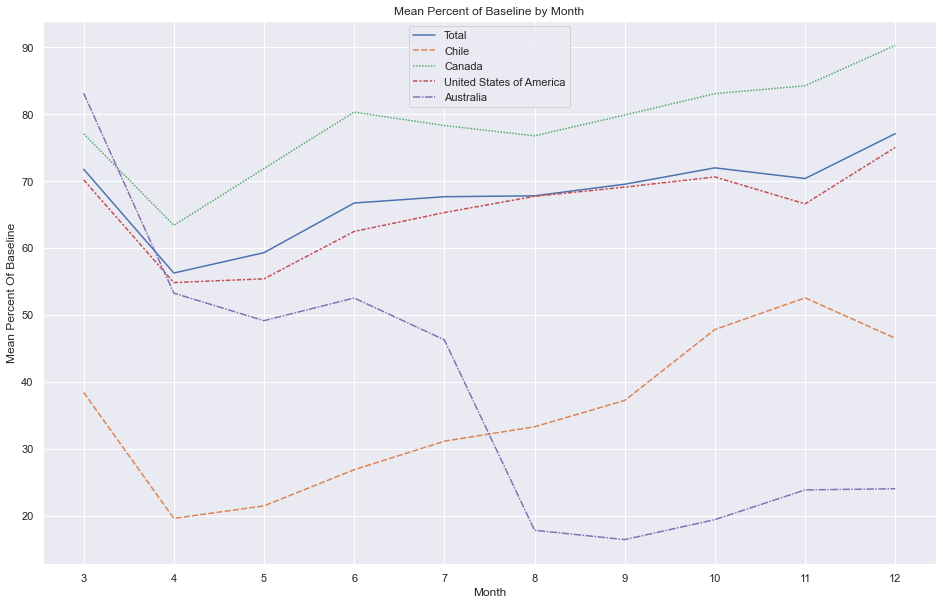

In [16]:
# Plot the graph
sns.set(font_scale=1.0)
plt.figure(figsize=[16, 10])
sns.lineplot(data=df_month)
plt.ylabel('Mean Percent Of Baseline')
plt.title('Mean Percent of Baseline by Month')
plt.xticks(range(3,13))
plt.show()

3e. Visualization of the confirmed covid-19 cases statistics

In [17]:
# We want to see what is the total amount of confirmed covid-19 cases for each country.
# Remove all non-target countries
df2_country_clean = df2[(df2['Country/Region'] == 'Chile') |
                    (df2['Country/Region'] == 'Australia') |
                    (df2['Country/Region'] == 'Canada') |
                    (df2['Country/Region'] == 'US')].copy(deep=True)
df2_country_clean.drop(columns='Province/State', inplace=True)

# Combine statistic of all Province/State from the same country
df2_group = df2_country_clean.groupby(by='Country/Region')
df2_country_clean_uniq = pd.DataFrame()
df2_country_clean_uniq = df2_country_clean_uniq.append(df2_group.get_group('Australia').sum(), ignore_index=True)
df2_country_clean_uniq = df2_country_clean_uniq.append(df2_group.get_group('Canada').sum(), ignore_index=True)
df2_country_clean_uniq = df2_country_clean_uniq.append(df2_group.get_group('Chile'), ignore_index=True)
df2_country_clean_uniq = df2_country_clean_uniq.append(df2_group.get_group('US'), ignore_index=True)
df2_country_clean_uniq.loc[0, 'Country/Region'] = 'Australia'
df2_country_clean_uniq.loc[1, 'Country/Region'] = 'Canada'
df2_country_clean_uniq.set_index('Country/Region', inplace=True)
df2_country_clean_uniq

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,8/29/21,8/30/21,8/31/21,9/1/21,9/2/21,9/3/21,9/4/21,9/5/21,9/6/21,9/7/21
Country/Region,,,,,,,,,,,,,,,,,,,,,
Australia,0.0,0.0,0.0,0.0,4.0,5.0,5.0,6.0,9.0,9.0,...,52611.0,53868.0,55093.0,56560.0,58208.0,59949.0,61619.0,63155.0,64621.0,66317.0
Canada,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,4.0,...,1497283.0,1504157.0,1507092.0,1511046.0,1515042.0,1519248.0,1520892.0,1522625.0,1523668.0,1533589.0
Chile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1637829.0,1638330.0,1638675.0,1639123.0,1639698.0,1640192.0,1640666.0,1641091.0,1641526.0,1641791.0
US,1.0,1.0,2.0,2.0,5.0,5.0,5.0,6.0,6.0,8.0,...,38798889.0,39057426.0,39198131.0,39396156.0,39549299.0,39850260.0,39906431.0,39944992.0,40018318.0,40280001.0


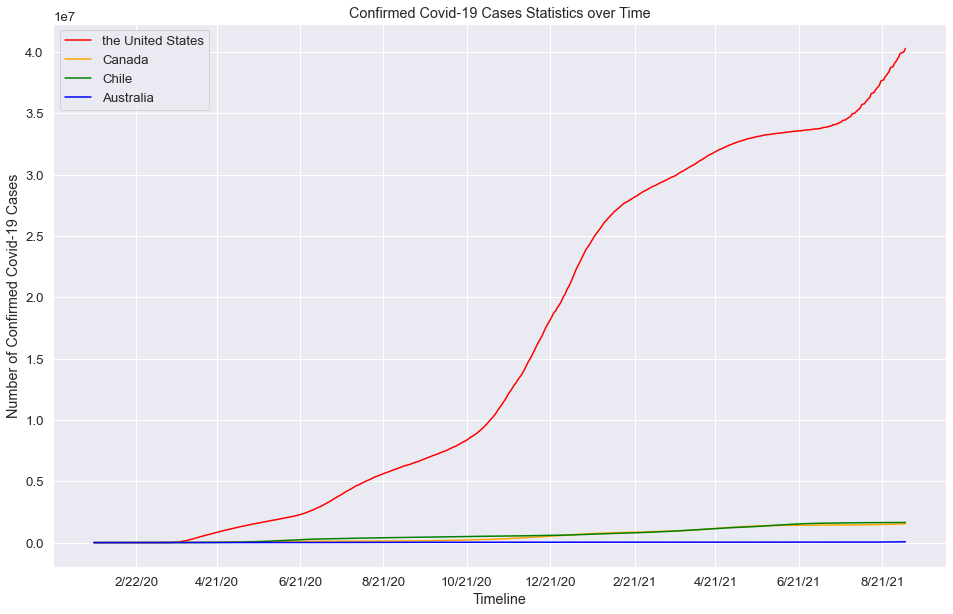

In [18]:
# Plot the data of general trends
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(16, 10))
sns.lineplot(data=df2_country_clean_uniq.loc['US'], color='red', label='the United States')
sns.lineplot(data=df2_country_clean_uniq.loc['Canada'], color='orange', label='Canada')
sns.lineplot(data=df2_country_clean_uniq.loc['Chile'], color='green', label='Chile')
sns.lineplot(data=df2_country_clean_uniq.loc['Australia'], color='blue', label='Australia')
plt.ylabel('Number of Confirmed Covid-19 Cases')
plt.xlabel('Timeline')
plt.title('Confirmed Covid-19 Cases Statistics over Time')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.show()

In [19]:
# The US is a coutry with large population so that its data stand out in the graph we observed above. To be able to grasp the trends of other
# countries better, we tries to standize all variables, based on total population in each country.
# Info from Worldometers, population of theses countries in 2020.
pop_us = 331449281
pop_ca = 37742154
pop_au = 25694393
pop_chile = 19116201
std = df2_country_clean_uniq.copy(deep=True)
std.loc['US'] = std.loc['US']/pop_us*100
std.loc['Canada'] = std.loc['Canada']/pop_ca*100
std.loc['Australia'] = std.loc['Australia']/pop_au*100
std.loc['Chile'] = std.loc['Chile']/pop_chile*100

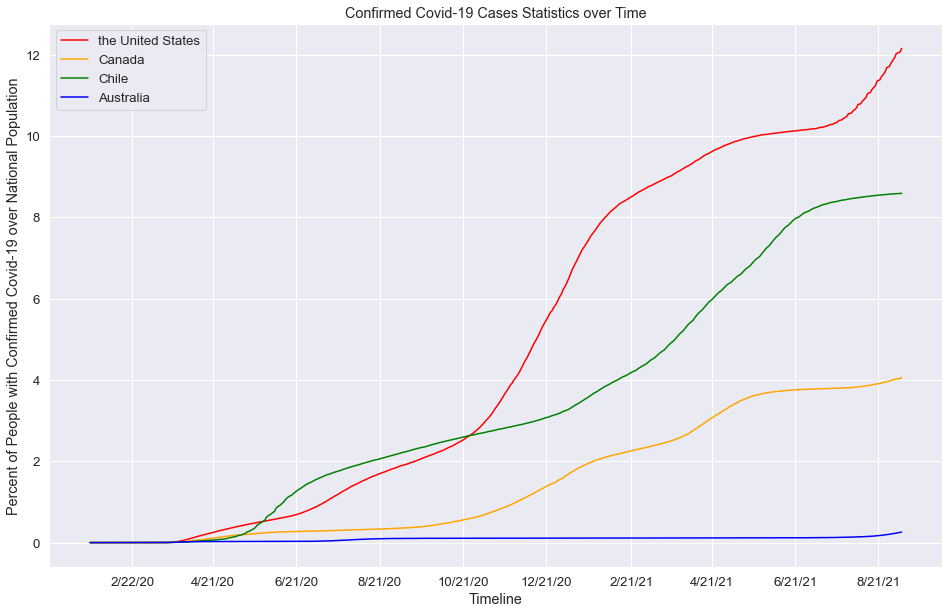

In [20]:
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(16, 10))
sns.lineplot(data=std.loc['US'], color='red', label='the United States')
sns.lineplot(data=std.loc['Canada'], color='orange', label='Canada')
sns.lineplot(data=std.loc['Chile'], color='green', label='Chile')
sns.lineplot(data=std.loc['Australia'], color='blue', label='Australia')
plt.ylabel('Percent of People with Confirmed Covid-19 over National Population')
plt.xlabel('Timeline')
plt.title('Confirmed Covid-19 Cases Statistics over Time')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.show()

In [21]:
# We want to compare confirmed cases dataset with our first dataset, 
# therefore, we want to limit the time interval to make two dataset consistent in time
# Remove all non-target dates 
# In Airport dateset,the time interval is from 3/16/2000 to 12/02/2000.
# Therefore, we want to compare relationship from April 2000 to November 2000 (Get rid of imcomplete months)
df2_date_clean = df2_country_clean_uniq[df2_country_clean_uniq.columns.drop(
                    list(df2_country_clean_uniq.filter(regex='^((.|..)/(.|..)/21)$|^(([1-3]|12)/(.|..)/20)$')))].copy(deep=True)


df2_date_clean

,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,...,11/21/20,11/22/20,11/23/20,11/24/20,11/25/20,11/26/20,11/27/20,11/28/20,11/29/20,11/30/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Australia,4862.0,5116.0,5330.0,5550.0,5687.0,5797.0,5895.0,6010.0,6108.0,6215.0,...,27821.0,27834.0,27843.0,27853.0,27865.0,27873.0,27886.0,27892.0,27902.0,27912.0
Canada,10527.0,12219.0,13559.0,14906.0,16475.0,17521.0,18858.0,20122.0,21502.0,22777.0,...,330240.0,335038.0,341746.0,347135.0,352376.0,357926.0,363884.0,369510.0,374880.0,382708.0
Chile,3137.0,3510.0,3843.0,4355.0,4665.0,5009.0,5310.0,5740.0,6166.0,6695.0,...,539143.0,540640.0,542080.0,543087.0,544092.0,545662.0,547243.0,548941.0,550430.0,551743.0
US,224583.0,256809.0,289116.0,321502.0,351397.0,382787.0,413566.0,444798.0,480743.0,515146.0,...,12213946.0,12360893.0,12534982.0,12710526.0,12893929.0,13006455.0,13214388.0,13370049.0,13510377.0,13670697.0


In [22]:
group_of_date = df_date.groupby(by=['Date'])
graph_data = pd.DataFrame()
date_list = df_date['Date'].unique()
graph_data['Date'] = date_list

chile_mpct = []
ca_mpct = []
us_mpct = []
au_mpct = []
for i in date_list:
    chile_mpct.append(group_of_date.get_group(i)[group_of_date.get_group(i)['Country'] == 'Chile']['PercentOfBaseline'].mean())
    ca_mpct.append(group_of_date.get_group(i)[group_of_date.get_group(i)['Country'] == 'Canada']['PercentOfBaseline'].mean())
    us_mpct.append(group_of_date.get_group(i)[group_of_date.get_group(i)['Country'] == 'United States of America (the)']['PercentOfBaseline'].mean())
    au_mpct.append(group_of_date.get_group(i)[group_of_date.get_group(i)['Country'] == 'Australia']['PercentOfBaseline'].mean())

date_str = []
for d in date_list:
    temp = pd.to_datetime(str(d))
    date_str.append(temp.strftime('%m/%d/%y'))

temp = []
for s in date_str:
    if s[0] == '0':
        temp.append(s[1:])
    else:
        temp.append(s)
date_str = temp
        
graph_data['Date'] = date_str
graph_data['AustraliaPercentOfBaseline'] = au_mpct
graph_data['CanadaPercentOfBaseline'] = ca_mpct
graph_data['ChilePercentOfBaseline'] = chile_mpct
graph_data['USPercentOfBaseline'] = us_mpct

# print(graph_data.isnull().sum())
# We notice there are missing dates, so we replace thoses cells with average pct of baseline
graph_data['AustraliaPercentOfBaseline'] = graph_data['AustraliaPercentOfBaseline'].fillna(graph_data['AustraliaPercentOfBaseline'].mean())
graph_data['ChilePercentOfBaseline'] = graph_data['ChilePercentOfBaseline'].fillna(graph_data['ChilePercentOfBaseline'].mean())
graph_data = graph_data.transpose().set_axis(graph_data['Date'], axis = 1)
graph_data.drop('Date', inplace=True)
graph_data = graph_data[graph_data.columns.drop(list(graph_data.filter(regex='^((.|..)/(.|..)/21)$|^(([1-3]|12)/(.|..)/20)$')))]
graph_data.loc[''] = list(df2_date_clean.columns)
graph_data.columns = graph_data.loc['']
graph_data.drop('', inplace=True)
graph_data

,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,...,11/21/20,11/22/20,11/23/20,11/24/20,11/25/20,11/26/20,11/27/20,11/28/20,11/29/20,11/30/20
AustraliaPercentOfBaseline,69.0,77.0,64.0,27.0,57.0,59.0,64.0,69.0,54.0,8.0,...,33.0,18.0,22.0,25.0,28.0,25.0,18.0,46.0,28.0,29.0
CanadaPercentOfBaseline,70.666667,72.555556,67.0,51.375,42.666667,74.888889,72.444444,65.888889,67.222222,18.375,...,80.555556,66.222222,93.222222,89.333333,89.0,87.333333,86.333333,83.444444,80.777778,91.111111
ChilePercentOfBaseline,27.0,21.0,31.0,19.0,11.0,27.0,25.0,21.0,24.0,12.0,...,31.0,26.0,58.0,44.0,47.0,50.0,48.0,39.0,34.273109,65.0
USPercentOfBaseline,62.588235,58.705882,56.941176,51.058824,47.764706,59.0,59.294118,59.882353,56.235294,52.235294,...,67.823529,65.235294,74.882353,73.058824,69.470588,29.470588,36.588235,58.235294,64.0,69.294118


In [23]:
# Make plot of each country to see their trends.

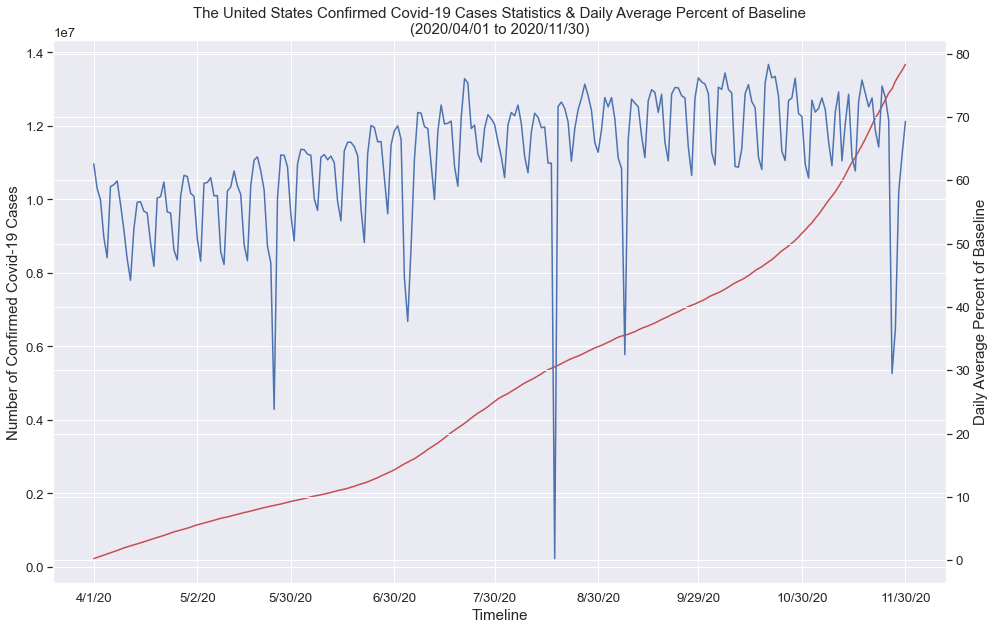

In [24]:
fig, ax1 = plt.subplots(figsize=(16, 10))
ax2 = ax1.twinx()
x = df2_date_clean.columns
x_range = list(range(1,245))
y1 = df2_date_clean.loc['US']
y2 = graph_data.loc['USPercentOfBaseline']
ax1.plot(x, y1, 'r-')
ax2.plot(x, y2, 'b-')
ax1.set_ylabel('Number of Confirmed Covid-19 Cases', fontsize=15)
ax2.set_ylabel('Daily Average Percent of Baseline', fontsize=15)
ax1.set_xlabel('Timeline', fontsize=15)
plt.title('The United States Confirmed Covid-19 Cases Statistics & Daily Average Percent of Baseline\n(2020/04/01 to 2020/11/30)', fontsize=15)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.show()

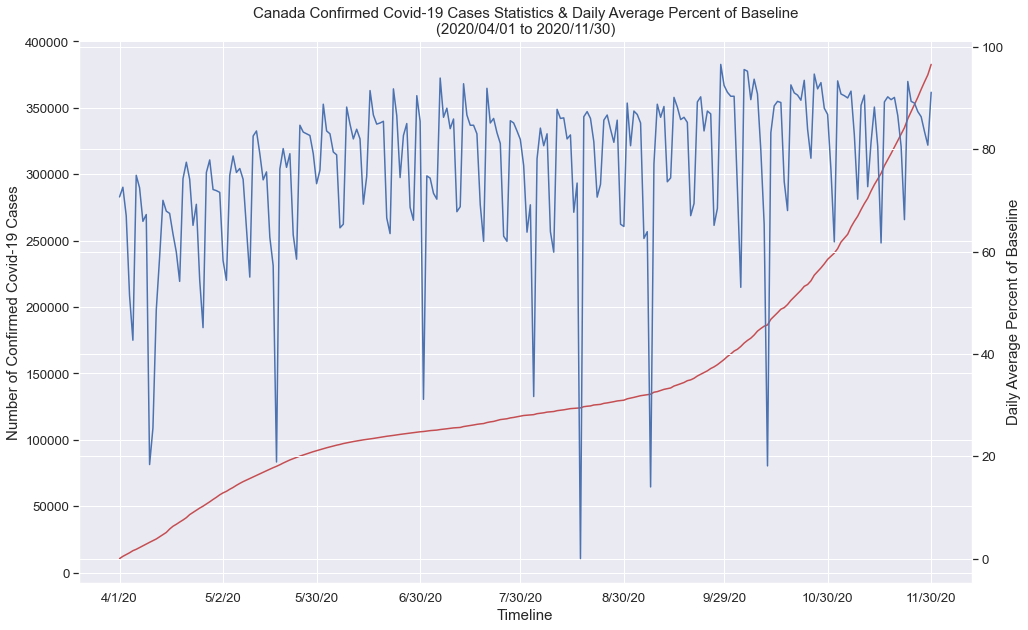

In [25]:
fig, ax1 = plt.subplots(figsize=(16, 10))
ax2 = ax1.twinx()
x = df2_date_clean.columns
y1 = df2_date_clean.loc['Canada']
y2 = graph_data.loc['CanadaPercentOfBaseline']
ax1.plot(x, y1, 'r-')
ax2.plot(x, y2, 'b-')
ax1.set_ylabel('Number of Confirmed Covid-19 Cases', fontsize=15)
ax2.set_ylabel('Daily Average Percent of Baseline', fontsize=15)
ax1.set_xlabel('Timeline', fontsize=15)
plt.title('Canada Confirmed Covid-19 Cases Statistics & Daily Average Percent of Baseline\n(2020/04/01 to 2020/11/30)', fontsize=15)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.show()

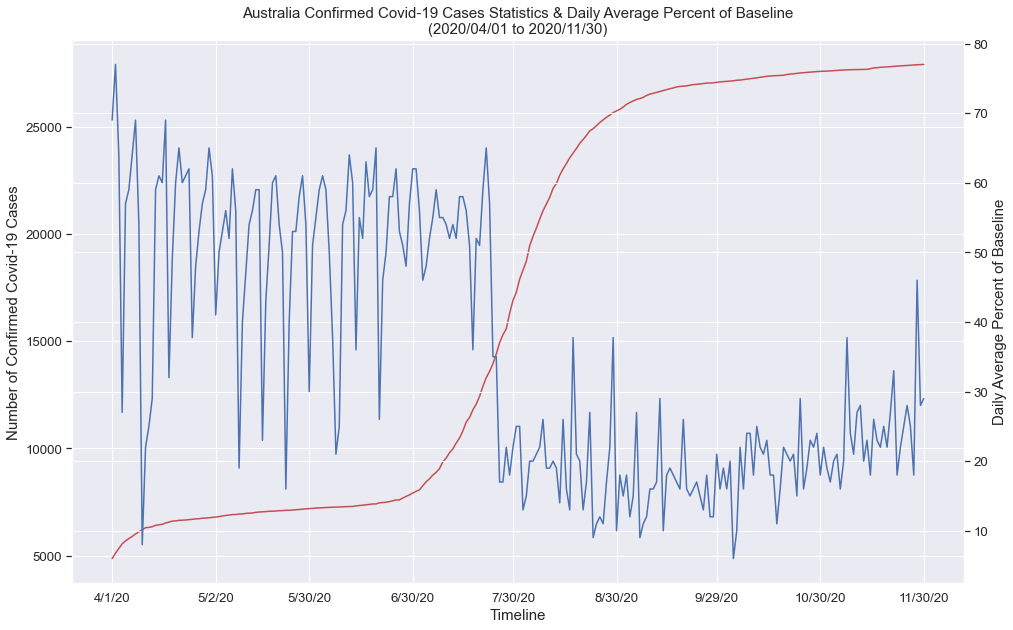

In [26]:
fig, ax1 = plt.subplots(figsize=(16, 10))
ax2 = ax1.twinx()
x = df2_date_clean.columns
y1 = df2_date_clean.loc['Australia']
y2 = graph_data.loc['AustraliaPercentOfBaseline']
ax1.plot(x, y1, 'r-')
ax2.plot(x, y2, 'b-')
ax1.set_ylabel('Number of Confirmed Covid-19 Cases', fontsize=15)
ax2.set_ylabel('Daily Average Percent of Baseline', fontsize=15)
ax1.set_xlabel('Timeline', fontsize=15)
plt.title('Australia Confirmed Covid-19 Cases Statistics & Daily Average Percent of Baseline\n(2020/04/01 to 2020/11/30)', fontsize=15)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.show()

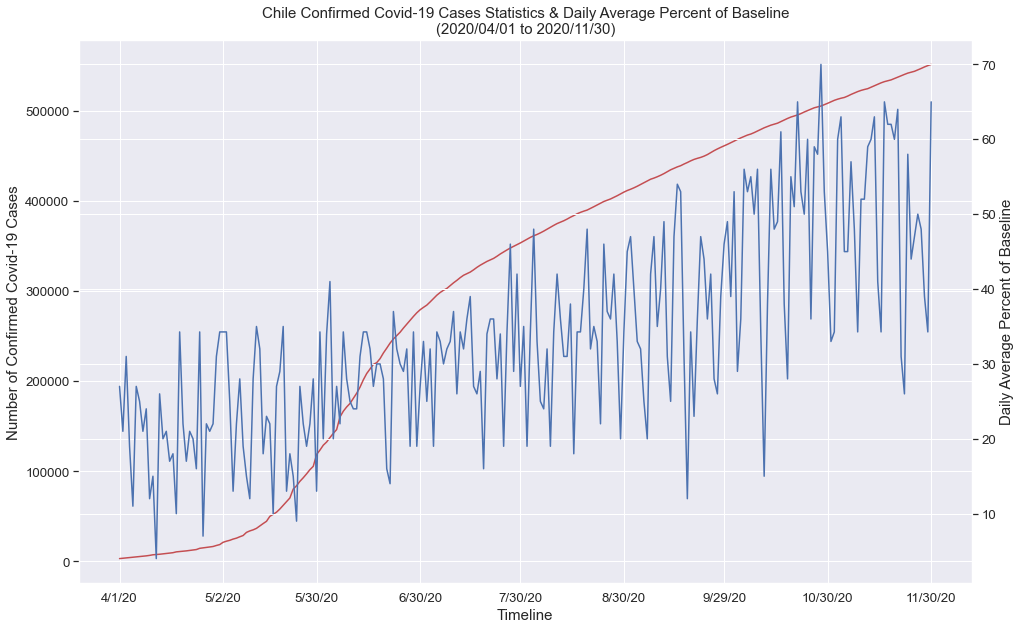

In [27]:
fig, ax1 = plt.subplots(figsize=(16, 10))
ax2 = ax1.twinx()
x = df2_date_clean.columns
y1 = df2_date_clean.loc['Chile']
y2 = graph_data.loc['ChilePercentOfBaseline']
ax1.plot(x, y1, 'r-')
ax2.plot(x, y2, 'b-')
ax1.set_ylabel('Number of Confirmed Covid-19 Cases', fontsize=15)
ax2.set_ylabel('Daily Average Percent of Baseline', fontsize=15)
ax1.set_xlabel('Timeline', fontsize=15)
plt.title('Chile Confirmed Covid-19 Cases Statistics & Daily Average Percent of Baseline\n(2020/04/01 to 2020/11/30)', fontsize=15)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.show()

3f. Explore correlation between Percent of Baseline and # confirmed covid-19 case.

In [28]:
df_3f = graph_data.copy(deep=True)
df_3f = df_3f.append(df2_date_clean)
df_3f = df_3f.rename(index={'Australia':'AustraliaCovidStats','US':'USCovidStats','Canada':'CanadaCovidStats','Chile':'ChileCovidStats'})

df_3f.loc['AustraliaDailyIncrease'] = np.insert(np.diff(df_3f.loc['AustraliaCovidStats']),0,0)
df_3f.loc['CanadaDailyIncrease'] = np.insert(np.diff(df_3f.loc['CanadaCovidStats']),0,0)
df_3f.loc['ChileDailyIncrease'] = np.insert(np.diff(df_3f.loc['ChileCovidStats']),0,0)
df_3f.loc['USDailyIncrease'] = np.insert(np.diff(df_3f.loc['USCovidStats']),0,0)

df_3f

,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,...,11/21/20,11/22/20,11/23/20,11/24/20,11/25/20,11/26/20,11/27/20,11/28/20,11/29/20,11/30/20
AustraliaPercentOfBaseline,69.0,77.0,64.0,27.0,57.0,59.0,64.0,69.0,54.0,8.0,...,33.0,18.0,22.0,25.0,28.0,25.0,18.0,46.0,28.0,29.0
CanadaPercentOfBaseline,70.666667,72.555556,67.0,51.375,42.666667,74.888889,72.444444,65.888889,67.222222,18.375,...,80.555556,66.222222,93.222222,89.333333,89.0,87.333333,86.333333,83.444444,80.777778,91.111111
ChilePercentOfBaseline,27.0,21.0,31.0,19.0,11.0,27.0,25.0,21.0,24.0,12.0,...,31.0,26.0,58.0,44.0,47.0,50.0,48.0,39.0,34.273109,65.0
USPercentOfBaseline,62.588235,58.705882,56.941176,51.058824,47.764706,59.0,59.294118,59.882353,56.235294,52.235294,...,67.823529,65.235294,74.882353,73.058824,69.470588,29.470588,36.588235,58.235294,64.0,69.294118
AustraliaCovidStats,4862.0,5116.0,5330.0,5550.0,5687.0,5797.0,5895.0,6010.0,6108.0,6215.0,...,27821.0,27834.0,27843.0,27853.0,27865.0,27873.0,27886.0,27892.0,27902.0,27912.0
CanadaCovidStats,10527.0,12219.0,13559.0,14906.0,16475.0,17521.0,18858.0,20122.0,21502.0,22777.0,...,330240.0,335038.0,341746.0,347135.0,352376.0,357926.0,363884.0,369510.0,374880.0,382708.0
ChileCovidStats,3137.0,3510.0,3843.0,4355.0,4665.0,5009.0,5310.0,5740.0,6166.0,6695.0,...,539143.0,540640.0,542080.0,543087.0,544092.0,545662.0,547243.0,548941.0,550430.0,551743.0
USCovidStats,224583.0,256809.0,289116.0,321502.0,351397.0,382787.0,413566.0,444798.0,480743.0,515146.0,...,12213946.0,12360893.0,12534982.0,12710526.0,12893929.0,13006455.0,13214388.0,13370049.0,13510377.0,13670697.0
AustraliaDailyIncrease,0,254.0,214.0,220.0,137.0,110.0,98.0,115.0,98.0,107.0,...,15.0,13.0,9.0,10.0,12.0,8.0,13.0,6.0,10.0,10.0
CanadaDailyIncrease,0,1692.0,1340.0,1347.0,1569.0,1046.0,1337.0,1264.0,1380.0,1275.0,...,4884.0,4798.0,6708.0,5389.0,5241.0,5550.0,5958.0,5626.0,5370.0,7828.0


Pearsons correlation: 0.426869
Spearmans correlation: 0.646813


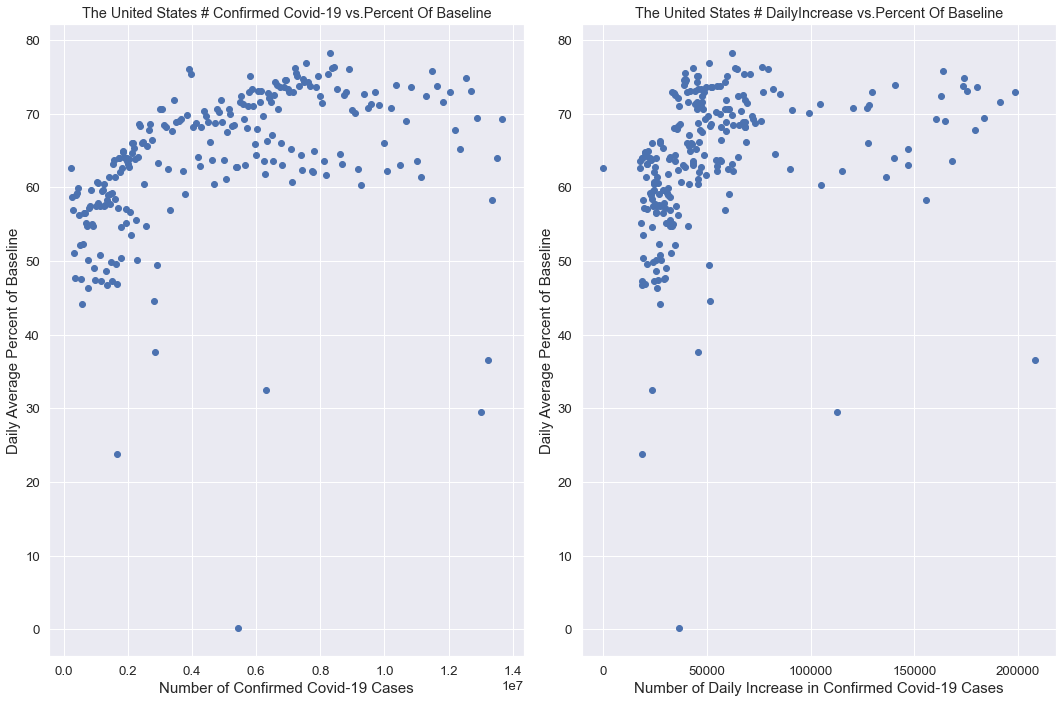

In [38]:
# The US
corr, _ = pearsonr(df_3f.loc['USPercentOfBaseline'], df_3f.loc['USCovidStats'])
print('Pearsons correlation: %f' % corr)
corr, _ = spearmanr(df_3f.loc['USPercentOfBaseline'], df_3f.loc['USCovidStats'])
print('Spearmans correlation: %f' % corr)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
y = df_3f.loc['USPercentOfBaseline']
x1 = df_3f.loc['USCovidStats']
x2 = df_3f.loc['USDailyIncrease']
axes[0].scatter(x1, y)
axes[1].scatter(x2, y)

axes[0].title.set_text('The United States # Confirmed Covid-19 vs.Percent Of Baseline')
axes[0].set_xlabel('Number of Confirmed Covid-19 Cases', fontsize=15)
axes[0].set_ylabel('Daily Average Percent of Baseline', fontsize=15)
axes[1].title.set_text('The United States # DailyIncrease vs.Percent Of Baseline')
axes[1].set_xlabel('Number of Daily Increase in Confirmed Covid-19 Cases', fontsize=15)
axes[1].set_ylabel('Daily Average Percent of Baseline', fontsize=15)
fig.tight_layout()

Pearsons correlation: -0.816090
Spearmans correlation: -0.646122


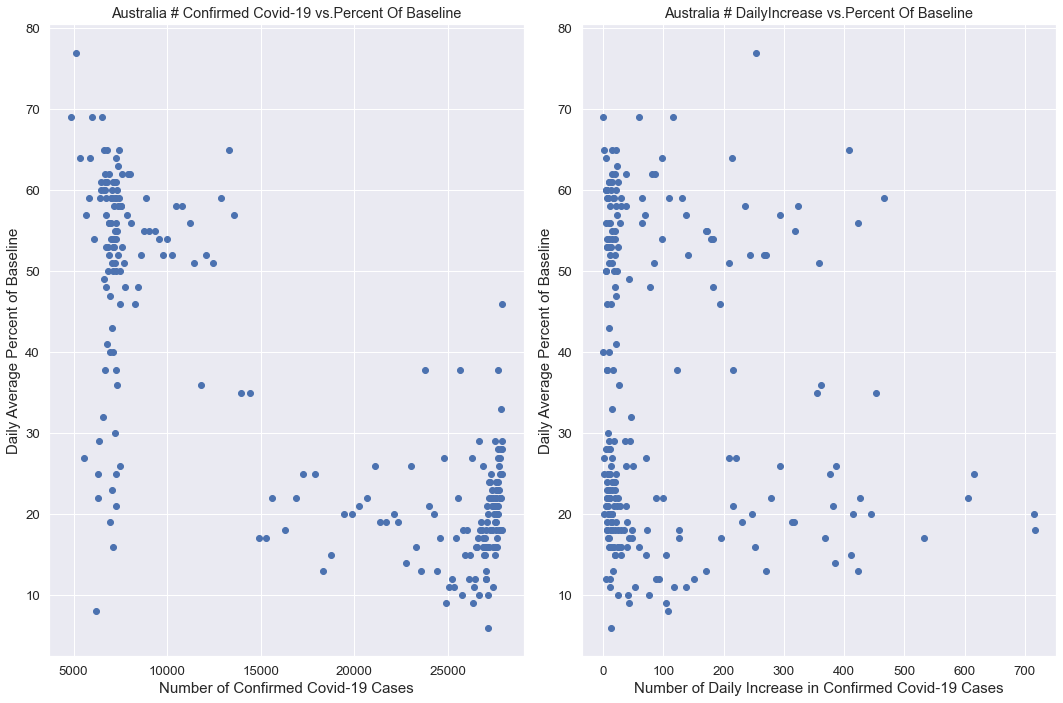

In [30]:
# Australia
corr, _ = pearsonr(df_3f.loc['AustraliaPercentOfBaseline'], df_3f.loc['AustraliaCovidStats'])
print('Pearsons correlation: %f' % corr)
corr, _ = spearmanr(df_3f.loc['AustraliaPercentOfBaseline'], df_3f.loc['AustraliaCovidStats'])
print('Spearmans correlation: %f' % corr)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
y = df_3f.loc['AustraliaPercentOfBaseline']
x1 = df_3f.loc['AustraliaCovidStats']
x2 = df_3f.loc['AustraliaDailyIncrease']
axes[0].scatter(x1, y)
axes[1].scatter(x2, y)

axes[0].title.set_text('Australia # Confirmed Covid-19 vs.Percent Of Baseline')
axes[0].set_xlabel('Number of Confirmed Covid-19 Cases', fontsize=15)
axes[0].set_ylabel('Daily Average Percent of Baseline', fontsize=15)
axes[1].title.set_text('Australia # DailyIncrease vs.Percent Of Baseline')
axes[1].set_xlabel('Number of Daily Increase in Confirmed Covid-19 Cases', fontsize=15)
axes[1].set_ylabel('Daily Average Percent of Baseline', fontsize=15)
fig.tight_layout()

Pearsons correlation: 0.365973
Spearmans correlation: 0.502119


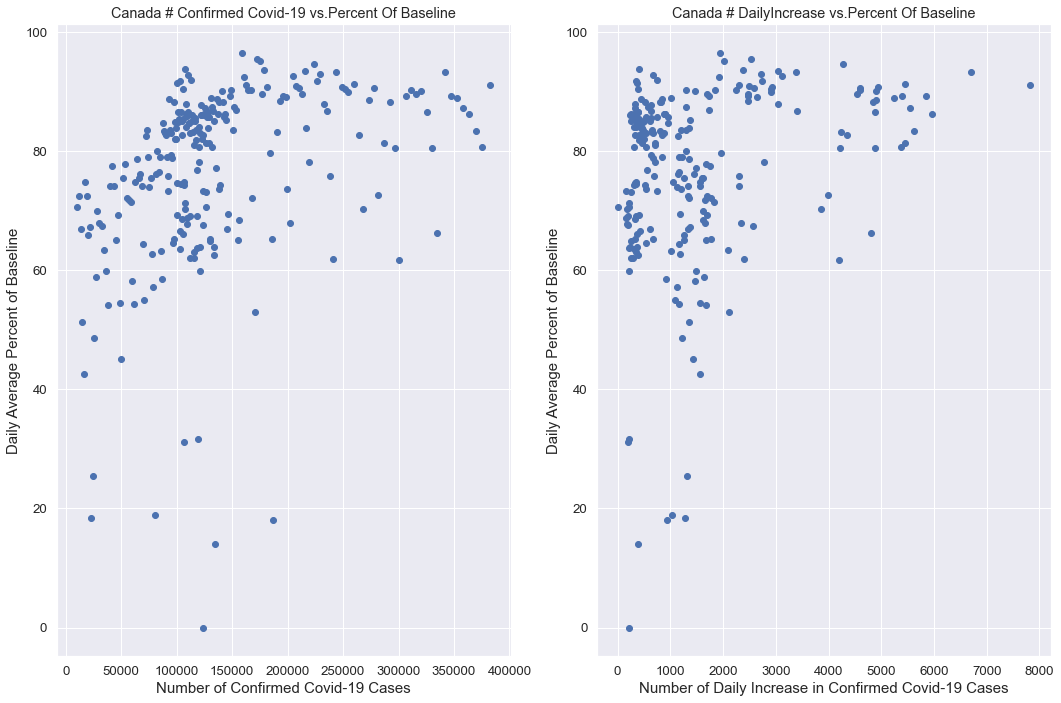

In [31]:
# Canada
corr, _ = pearsonr(df_3f.loc['CanadaPercentOfBaseline'], df_3f.loc['CanadaCovidStats'])
print('Pearsons correlation: %f' % corr)
corr, _ = spearmanr(df_3f.loc['CanadaPercentOfBaseline'], df_3f.loc['CanadaCovidStats'])
print('Spearmans correlation: %f' % corr)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
y = df_3f.loc['CanadaPercentOfBaseline']
x1 = df_3f.loc['CanadaCovidStats']
x2 = df_3f.loc['CanadaDailyIncrease']
axes[0].scatter(x1, y)
axes[1].scatter(x2, y)

axes[0].title.set_text('Canada # Confirmed Covid-19 vs.Percent Of Baseline')
axes[0].set_xlabel('Number of Confirmed Covid-19 Cases', fontsize=15)
axes[0].set_ylabel('Daily Average Percent of Baseline', fontsize=15)
axes[1].title.set_text('Canada # DailyIncrease vs.Percent Of Baseline')
axes[1].set_xlabel('Number of Daily Increase in Confirmed Covid-19 Cases', fontsize=15)
axes[1].set_ylabel('Daily Average Percent of Baseline', fontsize=15)
fig.tight_layout()

Pearsons correlation: 0.692734
Spearmans correlation: 0.719762


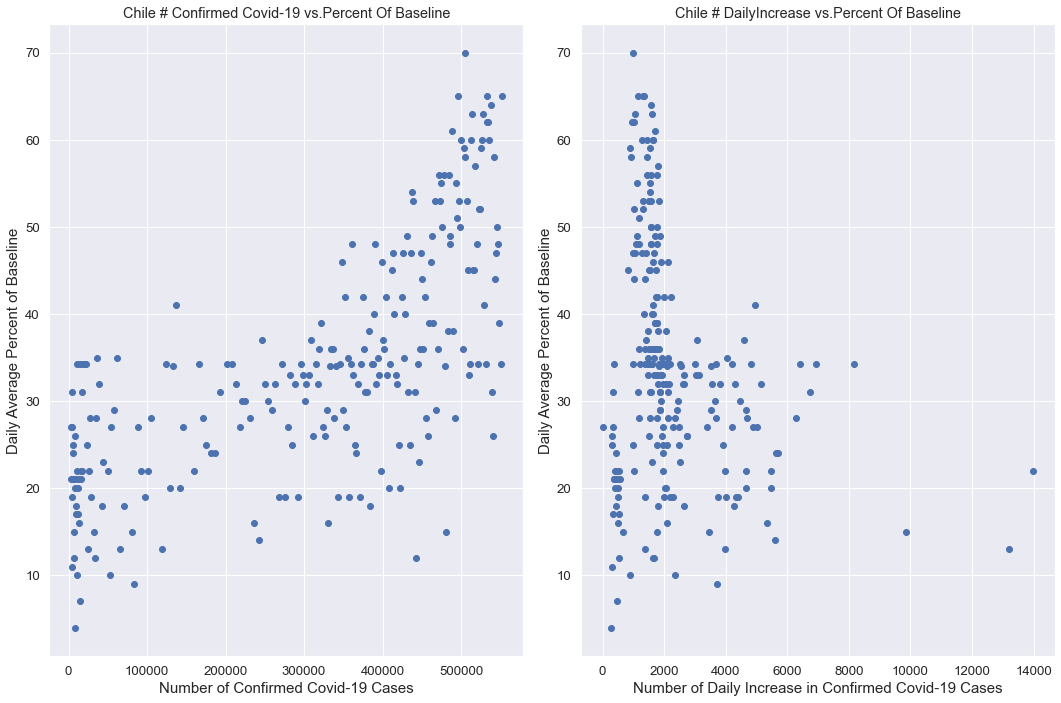

In [32]:
# Chile
corr, _ = pearsonr(df_3f.loc['ChilePercentOfBaseline'], df_3f.loc['ChileCovidStats'])
print('Pearsons correlation: %f' % corr)
corr, _ = spearmanr(df_3f.loc['ChilePercentOfBaseline'], df_3f.loc['ChileCovidStats'])
print('Spearmans correlation: %f' % corr)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
y = df_3f.loc['ChilePercentOfBaseline']
x1 = df_3f.loc['ChileCovidStats']
x2 = df_3f.loc['ChileDailyIncrease']
axes[0].scatter(x1, y)
axes[1].scatter(x2, y)

axes[0].title.set_text('Chile # Confirmed Covid-19 vs.Percent Of Baseline')
axes[0].set_xlabel('Number of Confirmed Covid-19 Cases', fontsize=15)
axes[0].set_ylabel('Daily Average Percent of Baseline', fontsize=15)
axes[1].title.set_text('Chile # DailyIncrease vs.Percent Of Baseline')
axes[1].set_xlabel('Number of Daily Increase in Confirmed Covid-19 Cases', fontsize=15)
axes[1].set_ylabel('Daily Average Percent of Baseline', fontsize=15)
fig.tight_layout()